In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1)

d = 128
block = 32
n = 32   # number of vectors in the bag
assert d % block == 0

print("Config:", {"d": d, "block": block, "n": n})

Config: {'d': 128, 'block': 32, 'n': 32}


In [2]:
def hadamard_matrix(n):
    assert (n & (n-1)) == 0, "n must be power of 2"
    H = np.array([[1]], dtype=np.float32)
    while H.shape[0] < n:
        H = np.block([[H, H],
                      [H, -H]])
    return H / np.sqrt(n)

H32 = hadamard_matrix(n)

# Check orthogonality
print("Orthogonality error:",
      np.max(np.abs(H32 @ H32.T - np.eye(n))))

Orthogonality error: 5.960464477539063e-08


In [3]:
def l2_normalize(x, eps=1e-12):
    return x / max(np.linalg.norm(x), eps)

def quantize_int8_blockwise(x, block=32):
    x = x.astype(np.float32, copy=False)
    d = x.shape[0]
    nb = d // block
    q = np.empty(d, dtype=np.int8)
    scales = np.empty(nb, dtype=np.float32)
    for b in range(nb):
        s = b * block
        e = s + block
        xb = x[s:e]
        scale = (np.max(np.abs(xb)) / 127.0) + 1e-12
        scales[b] = scale
        q[s:e] = np.round(xb / scale).astype(np.int8)
    return q, scales

def dot_q8_v8_blockwise(q8, qs, v8, vs, block=32):
    nb = q8.shape[0] // block
    acc = 0.0
    for b in range(nb):
        s = b * block
        e = s + block
        di = int(np.dot(q8[s:e].astype(np.int32),
                        v8[s:e].astype(np.int32)))
        acc += (qs[b] * vs[b]) * di
    return np.float32(acc)

In [4]:
# 32 database vectors
X = np.stack([l2_normalize(np.random.randn(d)) for _ in range(n)], axis=0).astype(np.float32)

# query
q = l2_normalize(np.random.randn(d)).astype(np.float32)

# true similarities
s_true = X @ q
true_top = int(np.argmax(s_true))

print("True top index:", true_top)

True top index: 2


In [5]:
Y = H32 @ X   # shape (32, d)

# quantise mixed rows
Yq = []
Ys = []
for k in range(n):
    y8, ys = quantize_int8_blockwise(Y[k], block=block)
    Yq.append(y8)
    Ys.append(ys)

Yq = np.stack(Yq, axis=0)
Ys = np.stack(Ys, axis=0)

# quantise query
q8, qs = quantize_int8_blockwise(q, block=block)

print("Stored DTDR object shape:", Yq.shape)

Stored DTDR object shape: (32, 128)


In [6]:
# s_y[k] = q · y_k  (computed in quantised DTDR domain)
s_y = np.array([
    dot_q8_v8_blockwise(q8, qs, Yq[k], Ys[k], block=block)
    for k in range(n)
], dtype=np.float32)

# reconstruct similarity to each original vector
s_hat = H32 @ s_y

print("DTDR top index:", int(np.argmax(s_hat)))
print("Matches float top:", int(np.argmax(s_hat)) == true_top)

print("MAE:", float(np.mean(np.abs(s_hat - s_true))))

DTDR top index: 2
Matches float top: True
MAE: 0.0005348508711904287


In [7]:
def progressive_reconstruction(s_y, H, order=None):
    n = H.shape[0]
    if order is None:
        order = list(range(n))  # natural order (Hadamard basis)

    sims_progressive = []
    accum = np.zeros(n, dtype=np.float32)

    for k in range(n):
        row = order[k]
        accum += H[:, row] * s_y[row]
        sims_progressive.append(accum.copy())

    return sims_progressive

# Use natural Hadamard order (coarse-to-fine already structured)
progress = progressive_reconstruction(s_y, H32)

top_indices = [int(np.argmax(p)) for p in progress]

print("Top index progression:")
print(top_indices[:10], "...", top_indices[-1])

Top index progression:
[0, 0, 0, 0, 0, 0, 0, 0, 8, 8] ... 2


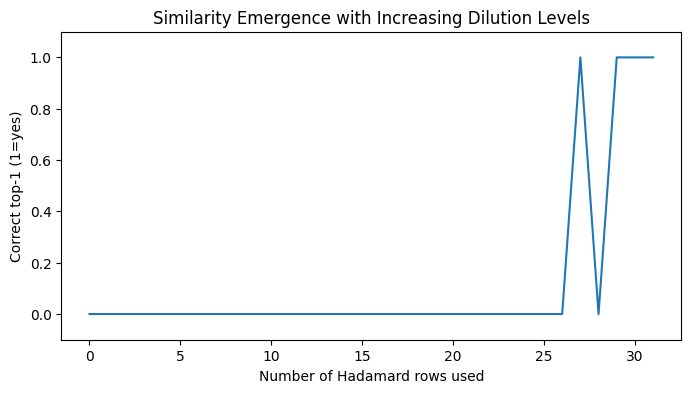

In [8]:
correct = [int(idx == true_top) for idx in top_indices]

plt.figure(figsize=(8,4))
plt.plot(correct)
plt.xlabel("Number of Hadamard rows used")
plt.ylabel("Correct top-1 (1=yes)")
plt.title("Similarity Emergence with Increasing Dilution Levels")
plt.ylim(-0.1,1.1)
plt.show()

In [9]:
# First k where top-1 becomes correct (this run)
first_correct = next((i+1 for i, idx in enumerate(top_indices) if idx == true_top), None)
print("First correct at rows used:", first_correct, "out of", n)

First correct at rows used: 28 out of 32


In [10]:
# Best-first row ordering by measured DTDR signal strength
order_best = list(np.argsort(-np.abs(s_y)))

progress_best = progressive_reconstruction(s_y, H32, order=order_best)
top_indices_best = [int(np.argmax(p)) for p in progress_best]

first_correct_best = next((i+1 for i, idx in enumerate(top_indices_best) if idx == true_top), None)
print("First correct with best-first |s_y| ordering:", first_correct_best, "out of", n)

# Optional: compare trajectories
print("First 10 top indices (best-first):", top_indices_best[:10])
print("Last top index:", top_indices_best[-1])

First correct with best-first |s_y| ordering: 3 out of 32
First 10 top indices (best-first): [0, 0, 2, 2, 2, 2, 29, 29, 2, 16]
Last top index: 2


In [11]:
def first_correct_k(top_indices, true_top):
    return next((i+1 for i, idx in enumerate(top_indices) if idx == true_top), None)

def stable_correct_k(top_indices, true_top):
    # earliest k such that for all j>=k, top_indices[j]==true_top
    for k in range(len(top_indices)):
        if all(idx == true_top for idx in top_indices[k:]):
            return k+1
    return None

k1 = first_correct_k(top_indices_best, true_top)
ks = stable_correct_k(top_indices_best, true_top)

print("Best-first order:")
print("  first correct k =", k1)
print("  stable correct k =", ks)

Best-first order:
  first correct k = 3
  stable correct k = 18


In [13]:
def run_one_trial():
    X = np.stack([l2_normalize(np.random.randn(d)) for _ in range(n)], axis=0).astype(np.float32)
    q = l2_normalize(np.random.randn(d)).astype(np.float32)
    s_true = X @ q
    true_top = int(np.argmax(s_true))

    Y = H32 @ X

    # quantise mixed rows
    Yq = []
    Ys = []
    for k in range(n):
        y8, ys = quantize_int8_blockwise(Y[k], block=block)
        Yq.append(y8); Ys.append(ys)
    Yq = np.stack(Yq, axis=0)
    Ys = np.stack(Ys, axis=0)

    q8, qs = quantize_int8_blockwise(q, block=block)

    s_y = np.array([dot_q8_v8_blockwise(q8, qs, Yq[k], Ys[k], block=block) for k in range(n)], dtype=np.float32)

    order_best = list(np.argsort(-np.abs(s_y)))
    progress_best = progressive_reconstruction(s_y, H32, order=order_best)
    top_indices_best = [int(np.argmax(p)) for p in progress_best]

    k_first = first_correct_k(top_indices_best, true_top)
    k_stab  = stable_correct_k(top_indices_best, true_top)
    return k_first, k_stab

T = 500  # bump to 2000 later
k_first_list = []
k_stab_list = []
for _ in range(T):
    kf, ks = run_one_trial()
    k_first_list.append(kf)
    k_stab_list.append(ks)

# Filter out None values
k_stab_clean = [k for k in k_stab_list if k is not None]

print("Trials:", T)
print("Median first-correct k:", int(np.median(k_first_list)))
print("Mean first-correct k:", float(np.mean(k_first_list)))

if len(k_stab_clean) > 0:
    print("Median stable-correct k:", int(np.median(k_stab_clean)))
    print("Mean stable-correct k:", float(np.mean(k_stab_clean)))
    print("Fraction with stable region:", len(k_stab_clean)/T)
else:
    print("No trials had stable prefix.")

Trials: 500
Median first-correct k: 8
Mean first-correct k: 9.148
Median stable-correct k: 15
Mean stable-correct k: 15.210526315789474
Fraction with stable region: 0.988


In [14]:
def first_correct_k(top_indices, true_top):
    return next((i+1 for i, idx in enumerate(top_indices) if idx == true_top), None)

def stable_correct_k(top_indices, true_top):
    for k in range(len(top_indices)):
        if all(idx == true_top for idx in top_indices[k:]):
            return k+1
    return None

def certified_k_from_progress(progress_sims, true_top, abs_sy_sorted, n):
    """
    progress_sims: list of partial reconstructed similarity vectors (length n), in the same order as abs_sy_sorted prefixes
    abs_sy_sorted: |s_y| sorted descending, so remaining bound after m terms is (1/sqrt(n))*sum_{k>=m} abs_sy_sorted[k]
    Returns smallest m that certifies winner via margin > 2R, else n.
    """
    sqrt_n = np.sqrt(n)
    total_tail = float(np.sum(abs_sy_sorted))
    tail = total_tail

    for m, s_hat in enumerate(progress_sims, start=1):
        # update tail: remove the just-added term
        tail -= float(abs_sy_sorted[m-1])
        R = tail / sqrt_n

        # top1/top2 margin from current partial reconstruction
        idx_sorted = np.argsort(-s_hat)
        i1, i2 = int(idx_sorted[0]), int(idx_sorted[1])
        margin = float(s_hat[i1] - s_hat[i2])

        # certificate
        if margin > 2 * R:
            return m

    return n

In [15]:
def run_one_trial_collect():
    X = np.stack([l2_normalize(np.random.randn(d)) for _ in range(n)], axis=0).astype(np.float32)
    q = l2_normalize(np.random.randn(d)).astype(np.float32)

    s_true = X @ q
    true_top = int(np.argmax(s_true))
    second = int(np.argsort(-s_true)[1])
    margin_true = float(s_true[true_top] - s_true[second])

    Y = H32 @ X

    # quantise mixed rows
    Yq = []
    Ys = []
    for k in range(n):
        y8, ys = quantize_int8_blockwise(Y[k], block=block)
        Yq.append(y8); Ys.append(ys)
    Yq = np.stack(Yq, axis=0)
    Ys = np.stack(Ys, axis=0)

    q8, qs = quantize_int8_blockwise(q, block=block)

    s_y = np.array([dot_q8_v8_blockwise(q8, qs, Yq[k], Ys[k], block=block) for k in range(n)], dtype=np.float32)

    # best-first order
    order_best = np.argsort(-np.abs(s_y))
    s_y_ordered = s_y[order_best]
    abs_sy_sorted = np.abs(s_y_ordered)

    # progressive reconstruction in that order:
    # when order is applied, the reconstruction update is: accum += H[:, row]*s_y[row]
    # so pass 'order_best' into your progressive reconstruction
    progress = progressive_reconstruction(s_y, H32, order=list(order_best))
    top_indices = [int(np.argmax(p)) for p in progress]

    k_first = first_correct_k(top_indices, true_top)
    k_stab = stable_correct_k(top_indices, true_top)
    k_cert = certified_k_from_progress(progress, true_top, abs_sy_sorted, n)

    return margin_true, k_first, k_stab, k_cert

T = 500
margins = []
k_firsts = []
k_stabs = []
k_certs = []

for _ in range(T):
    m, kf, ks, kc = run_one_trial_collect()
    margins.append(m)
    k_firsts.append(kf)
    k_stabs.append(ks)
    k_certs.append(kc)

print("Trials:", T)
print("Median margin:", float(np.median(margins)))
print("Median k_first:", int(np.median(k_firsts)))
print("Median k_stable (ignoring None):", int(np.median([k for k in k_stabs if k is not None])))
print("Median k_cert:", int(np.median(k_certs)))

Trials: 500
Median margin: 0.027622006833553314
Median k_first: 7
Median k_stable (ignoring None): 16
Median k_cert: 26


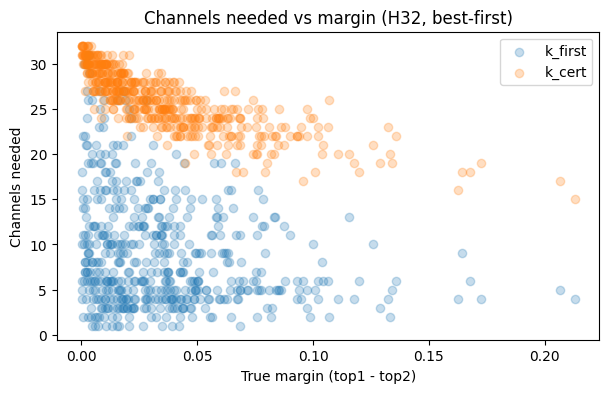

In [16]:
plt.figure(figsize=(7,4))
plt.scatter(margins, k_firsts, alpha=0.25, label="k_first")
plt.scatter(margins, k_certs, alpha=0.25, label="k_cert")
plt.xlabel("True margin (top1 - top2)")
plt.ylabel("Channels needed")
plt.title("Channels needed vs margin (H32, best-first)")
plt.legend()
plt.show()

In [19]:
# ============================================================
# GloVe H32 Progressive Emergence Experiment
# ============================================================

import os
import numpy as np

GLOVE_PATH = r"G:\train_jw\data\glove\glove.6B.100d.txt"

assert os.path.exists(GLOVE_PATH), "GloVe file not found"

print("Loading GloVe from:", GLOVE_PATH)

# ---- Load subset for speed ----
MAX_VECS = 20000
glove_vecs = []

with open(GLOVE_PATH, "r", encoding="utf-8") as f:
    for i, line in enumerate(f):
        if i >= MAX_VECS:
            break
        parts = line.strip().split()
        vec = np.array(parts[1:], dtype=np.float32)
        glove_vecs.append(vec)

X_full = np.stack(glove_vecs)
print("Loaded vectors:", X_full.shape)

# ---- L2 normalise ----
X_full /= np.linalg.norm(X_full, axis=1, keepdims=True)

# ---- H32 setup ----
n = 32
d = X_full.shape[1]

# ---- Simple Hadamard generator (power of 2 only) ----
def hadamard(n):
    assert (n & (n - 1)) == 0, "n must be power of 2"
    H = np.array([[1]], dtype=np.float32)
    while H.shape[0] < n:
        H = np.block([
            [H,  H],
            [H, -H]
        ])
    return H

Hn = hadamard(n).astype(np.float32) / np.sqrt(n)

print("Using n =", n, "  d =", d)

# ---- Trial function ----
def run_one_trial_glove():
    idx = np.random.choice(len(X_full), size=n+1, replace=False)
    X = X_full[idx[:n]]
    q = X_full[idx[n]]

    s_true = X @ q
    true_top = int(np.argmax(s_true))
    second = int(np.argsort(-s_true)[1])
    margin_true = float(s_true[true_top] - s_true[second])

    Y = Hn @ X

    Yq, Ys = [], []
    for k in range(n):
        y8, ys = quantize_int8_blockwise(Y[k], block=block)
        Yq.append(y8)
        Ys.append(ys)
    Yq = np.stack(Yq)
    Ys = np.stack(Ys)

    q8, qs = quantize_int8_blockwise(q, block=block)

    s_y = np.array([
        dot_q8_v8_blockwise(q8, qs, Yq[k], Ys[k], block=block)
        for k in range(n)
    ], dtype=np.float32)

    order = np.argsort(-np.abs(s_y))
    abs_sorted = np.abs(s_y[order])

    progress = progressive_reconstruction(s_y, Hn, order=list(order))
    top_indices = [int(np.argmax(p)) for p in progress]

    k_first = first_correct_k(top_indices, true_top)
    k_stab = stable_correct_k(top_indices, true_top)
    k_cert = certified_k_from_progress(progress, true_top, abs_sorted, n)

    return margin_true, k_first, k_stab, k_cert


# ---- Run trials ----
T = 500
margins, k_firsts, k_stabs, k_certs = [], [], [], []

for _ in range(T):
    m, kf, ks, kc = run_one_trial_glove()
    margins.append(m)
    k_firsts.append(kf)
    k_stabs.append(ks)
    k_certs.append(kc)

k_stab_clean = [k for k in k_stabs if k is not None]

k_first_clean = [k for k in k_firsts if k is not None]
k_stab_clean  = [k for k in k_stabs  if k is not None]

print("\n=== GloVe Results (100D) ===")
print("Trials:", T)
print("Median margin:", float(np.median(margins)))

if len(k_first_clean) > 0:
    print("Median k_first:", int(np.median(k_first_clean)))
    print("Mean k_first:", float(np.mean(k_first_clean)))
    print("Fraction first-correct exists:", len(k_first_clean)/T)
else:
    print("No first-correct cases.")

if len(k_stab_clean) > 0:
    print("Median k_stable:", int(np.median(k_stab_clean)))
    print("Mean k_stable:", float(np.mean(k_stab_clean)))
    print("Fraction stable exists:", len(k_stab_clean)/T)
else:
    print("No stable prefix cases.")

print("Median k_cert:", int(np.median(k_certs)))

Loading GloVe from: G:\train_jw\data\glove\glove.6B.100d.txt
Loaded vectors: (20000, 100)
Using n = 32   d = 100

=== GloVe Results (100D) ===
Trials: 500
Median margin: 0.05335749685764313
Median k_first: 7
Mean k_first: 8.946502057613168
Fraction first-correct exists: 0.972
Median k_stable: 12
Mean k_stable: 13.165158371040723
Fraction stable exists: 0.884
Median k_cert: 25


In [20]:
# ============================================================
# L1 vs L2 Certificate Comparison (best-first DTDR ordering)
# ============================================================

def certified_k_L1(progress_sims, true_top, abs_sy_sorted, n):
    """
    Conservative L1 tail bound:
      R = (1/sqrt(n)) * sum(|s_y remaining|)
    Stop when margin > 2R
    """
    sqrt_n = np.sqrt(n)
    tail_sum = float(np.sum(abs_sy_sorted))

    for m, s_hat in enumerate(progress_sims, start=1):
        tail_sum -= float(abs_sy_sorted[m-1])
        R = tail_sum / sqrt_n

        idx = np.argsort(-s_hat)
        margin = float(s_hat[idx[0]] - s_hat[idx[1]])
        if margin > 2 * R:
            return m
    return n


def certified_k_L2(progress_sims, true_top, sy_sorted, n, c=2.0):
    """
    Energy (L2) tail bound:
      R2 = (1/sqrt(n)) * sqrt(sum(s_y^2 remaining))
    Stop when margin > c * R2
    """
    sqrt_n = np.sqrt(n)
    tail_energy = float(np.sum(sy_sorted**2))

    for m, s_hat in enumerate(progress_sims, start=1):
        tail_energy -= float(sy_sorted[m-1]**2)
        R2 = np.sqrt(max(tail_energy, 0.0)) / sqrt_n

        idx = np.argsort(-s_hat)
        margin = float(s_hat[idx[0]] - s_hat[idx[1]])
        if margin > c * R2:
            return m
    return n


# ---- Run trials (uses the same run_one_trial_* logic inline) ----
def run_cert_trial(X_full):
    idx = np.random.choice(len(X_full), size=n+1, replace=False)
    X = X_full[idx[:n]]
    q = X_full[idx[n]]

    s_true = X @ q
    true_top = int(np.argmax(s_true))

    Y = Hn @ X

    Yq, Ys = [], []
    for k in range(n):
        y8, ys = quantize_int8_blockwise(Y[k], block=block)
        Yq.append(y8); Ys.append(ys)
    Yq = np.stack(Yq)
    Ys = np.stack(Ys)

    q8, qs = quantize_int8_blockwise(q, block=block)

    s_y = np.array([
        dot_q8_v8_blockwise(q8, qs, Yq[k], Ys[k], block=block)
        for k in range(n)
    ], dtype=np.float32)

    order = np.argsort(-np.abs(s_y))
    s_y_ord = s_y[order]
    abs_sy_ord = np.abs(s_y_ord)

    progress = progressive_reconstruction(s_y, Hn, order=list(order))

    k_L1 = certified_k_L1(progress, true_top, abs_sy_ord, n)
    k_L2 = certified_k_L2(progress, true_top, s_y_ord, n, c=2.0)

    return k_L1, k_L2


# ---- Choose dataset already loaded above ----
# For random tests, use X_full from random setup
# For GloVe tests, use X_full loaded from GloVe cell

T = 500
kL1, kL2 = [], []

for _ in range(T):
    a, b = run_cert_trial(X_full)
    kL1.append(a)
    kL2.append(b)

print("\n=== Certification Comparison ===")
print("Trials:", T)
print("Median k_cert (L1 bound):", int(np.median(kL1)))
print("Mean   k_cert (L1 bound):", float(np.mean(kL1)))
print("Median k_cert (L2 bound):", int(np.median(kL2)))
print("Mean   k_cert (L2 bound):", float(np.mean(kL2)))
print("Improvement (median):", int(np.median(kL1) - np.median(kL2)))


=== Certification Comparison ===
Trials: 500
Median k_cert (L1 bound): 25
Mean   k_cert (L1 bound): 24.896
Median k_cert (L2 bound): 18
Mean   k_cert (L2 bound): 18.174
Improvement (median): 7


In [21]:
# ============================================================
# FULL COMPARISON TABLE
# Random vs GloVe (100/200/300D)
# ============================================================

import os
import numpy as np

# ---------- Hadamard ----------
def hadamard(n):
    assert (n & (n - 1)) == 0
    H = np.array([[1]], dtype=np.float32)
    while H.shape[0] < n:
        H = np.block([[H, H], [H, -H]])
    return H

# ---------- Settings ----------
n = 32
T = 300   # reduce if slow

GLOVE_BASE = r"G:\train_jw\data\glove"

datasets = {
    "Random128": None,
    "GloVe100": os.path.join(GLOVE_BASE, "glove.6B.100d.txt"),
    "GloVe200": os.path.join(GLOVE_BASE, "glove.6B.200d.txt"),
    "GloVe300": os.path.join(GLOVE_BASE, "glove.6B.300d.txt"),
}

# ---------- Loader ----------
def load_glove(path, max_vecs=20000):
    vecs = []
    with open(path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if i >= max_vecs:
                break
            parts = line.strip().split()
            vec = np.array(parts[1:], dtype=np.float32)
            vecs.append(vec)
    X = np.stack(vecs)
    X /= np.linalg.norm(X, axis=1, keepdims=True)
    return X

# ---------- Trial runner ----------
def run_trials(X_full, d):
    Hn = hadamard(n).astype(np.float32) / np.sqrt(n)

    margins = []
    k_firsts = []
    k_stabs = []
    kL1 = []
    kL2 = []

    for _ in range(T):

        if X_full is None:
            # Random
            X = np.stack([np.random.randn(d) for _ in range(n)], axis=0).astype(np.float32)
            X /= np.linalg.norm(X, axis=1, keepdims=True)
            q = np.random.randn(d).astype(np.float32)
            q /= np.linalg.norm(q)
        else:
            idx = np.random.choice(len(X_full), size=n+1, replace=False)
            X = X_full[idx[:n]]
            q = X_full[idx[n]]

        s_true = X @ q
        true_top = int(np.argmax(s_true))
        second = int(np.argsort(-s_true)[1])
        margin = float(s_true[true_top] - s_true[second])

        Y = Hn @ X

        Yq, Ys = [], []
        for k in range(n):
            y8, ys = quantize_int8_blockwise(Y[k], block=block)
            Yq.append(y8); Ys.append(ys)
        Yq = np.stack(Yq)
        Ys = np.stack(Ys)

        q8, qs = quantize_int8_blockwise(q, block=block)

        s_y = np.array([
            dot_q8_v8_blockwise(q8, qs, Yq[k], Ys[k], block=block)
            for k in range(n)
        ], dtype=np.float32)

        order = np.argsort(-np.abs(s_y))
        s_y_ord = s_y[order]
        abs_sy_ord = np.abs(s_y_ord)

        progress = progressive_reconstruction(s_y, Hn, order=list(order))
        tops = [int(np.argmax(p)) for p in progress]

        kf = first_correct_k(tops, true_top)
        ks = stable_correct_k(tops, true_top)
        k1 = certified_k_L1(progress, true_top, abs_sy_ord, n)
        k2 = certified_k_L2(progress, true_top, s_y_ord, n)

        margins.append(margin)
        if kf is not None:
            k_firsts.append(kf)
        if ks is not None:
            k_stabs.append(ks)
        kL1.append(k1)
        kL2.append(k2)

    return {
        "margin": np.median(margins),
        "k_first": np.median(k_firsts),
        "k_stable": np.median(k_stabs),
        "k_L1": np.median(kL1),
        "k_L2": np.median(kL2),
    }


# ---------- Run ----------
results = {}

for name, path in datasets.items():

    print(f"\nRunning: {name}")

    if path is None:
        d = 128
        X_full = None
    else:
        assert os.path.exists(path), f"Missing file: {path}"
        X_full = load_glove(path)
        d = X_full.shape[1]

    results[name] = run_trials(X_full, d)

# ---------- Print Table ----------
print("\n================ FINAL COMPARISON ================")
print(f"{'Dataset':<12} {'d':<5} {'Margin':<10} {'k_first':<10} {'k_stable':<10} {'k_L1':<8} {'k_L2':<8}")

for name, res in results.items():
    d = 128 if name == "Random128" else int(name[-3:])
    print(f"{name:<12} {d:<5} "
          f"{res['margin']:<10.4f} "
          f"{int(res['k_first']):<10} "
          f"{int(res['k_stable']):<10} "
          f"{int(res['k_L1']):<8} "
          f"{int(res['k_L2']):<8}")


Running: Random128

Running: GloVe100

Running: GloVe200

Running: GloVe300

================ FINAL COMPARISON ================
Dataset      d     Margin     k_first    k_stable   k_L1     k_L2    
Random128    128   0.0280     7          15         26       19      
GloVe100     100   0.0546     7          11         25       16      
GloVe200     200   0.0421     7          14         25       18      
GloVe300     300   0.0416     6          11         25       17      


In [22]:
# ============================================================
# N-SCALING EXPERIMENT (GloVe300)
# ============================================================

import numpy as np
import os

GLOVE_PATH = r"G:\train_jw\data\glove\glove.6B.300d.txt"
assert os.path.exists(GLOVE_PATH)

print("Loading GloVe300 subset...")

# Load subset
def load_glove(path, max_vecs=30000):
    vecs = []
    with open(path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if i >= max_vecs:
                break
            parts = line.strip().split()
            vec = np.array(parts[1:], dtype=np.float32)
            vecs.append(vec)
    X = np.stack(vecs)
    X /= np.linalg.norm(X, axis=1, keepdims=True)
    return X

X_full = load_glove(GLOVE_PATH)
d = X_full.shape[1]

print("Vectors loaded:", X_full.shape)

# ---------- Scaling test ----------
def run_scaling(n, T=200):

    Hn = hadamard(n).astype(np.float32) / np.sqrt(n)

    margins = []
    k_stables = []
    k_L2s = []

    for _ in range(T):

        idx = np.random.choice(len(X_full), size=n+1, replace=False)
        X = X_full[idx[:n]]
        q = X_full[idx[n]]

        s_true = X @ q
        true_top = int(np.argmax(s_true))
        second = int(np.argsort(-s_true)[1])
        margin = float(s_true[true_top] - s_true[second])

        Y = Hn @ X

        Yq, Ys = [], []
        for k in range(n):
            y8, ys = quantize_int8_blockwise(Y[k], block=block)
            Yq.append(y8); Ys.append(ys)
        Yq = np.stack(Yq)
        Ys = np.stack(Ys)

        q8, qs = quantize_int8_blockwise(q, block=block)

        s_y = np.array([
            dot_q8_v8_blockwise(q8, qs, Yq[k], Ys[k], block=block)
            for k in range(n)
        ], dtype=np.float32)

        order = np.argsort(-np.abs(s_y))
        s_y_ord = s_y[order]

        progress = progressive_reconstruction(s_y, Hn, order=list(order))
        tops = [int(np.argmax(p)) for p in progress]

        ks = stable_correct_k(tops, true_top)
        k2 = certified_k_L2(progress, true_top, s_y_ord, n)

        margins.append(margin)
        if ks is not None:
            k_stables.append(ks)
        k_L2s.append(k2)

    return {
        "margin": np.median(margins),
        "k_stable": np.median(k_stables),
        "k_stable_ratio": np.median(k_stables)/n,
        "k_L2": np.median(k_L2s),
    }


ns = [16, 32, 64, 128]
scaling_results = {}

for n in ns:
    print("Running n =", n)
    scaling_results[n] = run_scaling(n)

print("\n================ N-SCALING (GloVe300) ================")
print(f"{'n':<6} {'margin':<10} {'k_stable':<10} {'k_stable/n':<12} {'k_L2':<8}")

for n in ns:
    r = scaling_results[n]
    print(f"{n:<6} {r['margin']:<10.4f} "
          f"{int(r['k_stable']):<10} "
          f"{r['k_stable_ratio']:<12.3f} "
          f"{int(r['k_L2']):<8}")

Loading GloVe300 subset...
Vectors loaded: (30000, 300)
Running n = 16
Running n = 32
Running n = 64
Running n = 128

================ N-SCALING (GloVe300) ================
n      margin     k_stable   k_stable/n   k_L2    
16     0.0365     5          0.312        9       
32     0.0374     12         0.375        17      
64     0.0366     24         0.375        32      
128    0.0302     52         0.406        69      


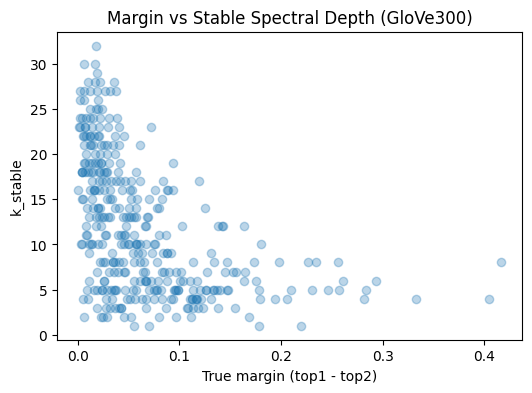

Correlation: -0.48860438070614465


In [23]:
# ============================================================
# Margin vs k_stable Scatter (GloVe300, n=32)
# ============================================================

import matplotlib.pyplot as plt

n = 32
Hn = hadamard(n).astype(np.float32) / np.sqrt(n)

T = 400

margins = []
k_stables = []

for _ in range(T):

    idx = np.random.choice(len(X_full), size=n+1, replace=False)
    X = X_full[idx[:n]]
    q = X_full[idx[n]]

    s_true = X @ q
    true_top = int(np.argmax(s_true))
    second = int(np.argsort(-s_true)[1])
    margin = float(s_true[true_top] - s_true[second])

    Y = Hn @ X

    Yq, Ys = [], []
    for k in range(n):
        y8, ys = quantize_int8_blockwise(Y[k], block=block)
        Yq.append(y8); Ys.append(ys)
    Yq = np.stack(Yq)
    Ys = np.stack(Ys)

    q8, qs = quantize_int8_blockwise(q, block=block)

    s_y = np.array([
        dot_q8_v8_blockwise(q8, qs, Yq[k], Ys[k], block=block)
        for k in range(n)
    ], dtype=np.float32)

    order = np.argsort(-np.abs(s_y))

    progress = progressive_reconstruction(s_y, Hn, order=list(order))
    tops = [int(np.argmax(p)) for p in progress]

    ks = stable_correct_k(tops, true_top)

    if ks is not None:
        margins.append(margin)
        k_stables.append(ks)

plt.figure(figsize=(6,4))
plt.scatter(margins, k_stables, alpha=0.3)
plt.xlabel("True margin (top1 - top2)")
plt.ylabel("k_stable")
plt.title("Margin vs Stable Spectral Depth (GloVe300)")
plt.show()

print("Correlation:", np.corrcoef(margins, k_stables)[0,1])